In [21]:
import wrds
import pandas as pd
import numpy as np
import os
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
script_dir = os.getcwd()

# Set the working directory to the current script's directory (which in this case is already the working directory)
os.chdir(script_dir)

print(f"Working directory is set to: {script_dir}")

# Connect to WRDS
db = wrds.Connection(wrds_username='zrsong')

# Define the start and end dates
start_date = '1990-01-01'
end_date = '2024-06-30'

Working directory is set to: /Users/zrsong/MIT Dropbox/Zirui Song/Research Projects/Direct Lending/Code
Loading library list...
Done


# Compustat

In [22]:
# import from data/raw folder with low_memory=False to avoid dtype warnings
df = pd.read_csv('../Data/Raw/crsp_compustat_merged_quarterly.csv', low_memory=False)
df.columns = df.columns.str.lower()  # ensure all dataframe column names are lower case

In [23]:
df = df.sort_values(['gvkey', 'fyearq', 'fqtr'])
# if there are duplicates of gvkey fyearq fqtr, sort by atq and keep the biggest one
df = df.drop_duplicates(subset=['gvkey', 'fyearq', 'fqtr', 'atq'], keep='last')

df['ebitda'] = df['oiadpq'] + df['dpq']
df['debt'] = df['dlttq'] + df['dlcq']
df['rnd'] = df['xrdq']
df['ppe'] = df['ppentq']

df['ebitda'] = df['ebitda'].interpolate(method='linear', limit_direction='both')
df['debt'] = df['debt'].interpolate(method='linear', limit_direction='both')
df['ppe'] = df['ppe'].interpolate(method='linear', limit_direction='both')
df['rnd'] = df['rnd'].interpolate(method='linear', limit_direction='both')
df['rnd'] = df['rnd'].fillna(0)

df['last_year_ebitda'] = df.groupby('gvkey')['ebitda'].transform(lambda x: x.rolling(window=4, min_periods=4).sum())
df['last_year_ebitda'] = df['last_year_ebitda'].interpolate(method='linear', limit_direction='both')

In [24]:
df['debt_to_ebitda'] = df['debt'] / df['last_year_ebitda']

df['assets'] = df['atq']
df['leverage'] = df['debt'] / df['assets']
df['current_ratio'] = df['actq'] / df['lctq']
df['market_cap'] = df['prccq'] * df['cshoq']
df['market_to_book'] = (df['market_cap'] + df['debt'] + df['pstkq']) / df['ceqq']

df['saleq'] = df['saleq'].interpolate(method='linear', limit_direction='both')
df['revtq'] = df['revtq'].interpolate(method='linear', limit_direction='both')
df['sales'] = df['saleq']
df['revenue'] = df['revtq']
# if revenue is empty, use sales
df['revenue'] = df['revenue'].fillna(df['sales'])


# CRSP 

In [25]:
# Define the variables to be imported
crsp_vars = ['cusip', 'permco', 'permno', 'date', 'ret', 'vol', 'shrout', 'prc']

# Define the query to get the annual returns of North American firms
crsp_query = f"""
    SELECT {', '.join(crsp_vars)}
    FROM crsp.msf
    WHERE date >= '{start_date}' AND date <= '{end_date}'
"""

# Execute the query and fetch the data
crspm = db.raw_sql(crsp_query, date_cols=['date'])

# Display the first few rows of the dataframe
print(crspm.head())

# header information from the CRSP file
crsp_hdr_query = """
    SELECT *
    FROM crsp.dsfhdr
"""

# Execute the query and fetch the data
crsp_hdr = db.raw_sql(crsp_hdr_query, date_cols=['date'])

# Display the first few rows of the dataframe
print(crsp_hdr.head())

# merge crspm and crsp_hdr with permno
crspm = crspm.merge(crsp_hdr[['permno', 'dlstcd']], on='permno', how='left')

# sort by permno date
crspm = crspm.sort_values(['permno', 'date'])

# Make sure data is sorted by permno and date
crspm = crspm.sort_values(['permno', 'date'])

      cusip  permco  permno       date       ret      vol  shrout      prc
0  36720410    7953   10001 1990-01-31 -0.018519    353.0  1022.0 -9.93750
1  05978R10    7954   10002 1990-01-31  0.020408     51.0  1175.0 -6.25000
2  39031810    7957   10003 1990-01-31 -0.088235   3214.0  2194.0  7.75000
3  95815510    7961   10005 1990-01-31  0.000000    252.0  8376.0 -0.06250
4  81949130    7963   10007 1990-01-31 -0.474886  13859.0  4120.0 -3.59375
   permno  permco  hshrcd  dlstcd    hcusip htick  \
0   10000    7952      10     560  68391610  None   
1   10001    7953      11     233  36720410  None   
2   10002    7954      11     231  05978R10  None   
3   10003    7957      11     231  39031810  None   
4   10004    7960      10     575  18906310  None   

                         hcomnam htsymbol  hnaics hprimexc  ...      begvol  \
0      OPTIMUM MANUFACTURING INC    OMFGA    None        Q  ...  1986-01-07   
1                GAS NATURAL INC     EGAS  221210        A  ...  1986-01-

In [26]:

# Compute the rolling 12-month (i.e. 12 observations) buy-and-hold return for each permno
crspm['rolling_12m_return'] = crspm.groupby('permno')['ret'] \
    .rolling(window=12, min_periods=12) \
    .apply(lambda x: np.prod(1 + x) - 1, raw=True) \
    .reset_index(level=0, drop=True)

# Compute the rolling 12-month return volatility (standard deviation)
crspm['rolling_12m_vol'] = crspm.groupby('permno')['ret'] \
    .rolling(window=12, min_periods=12) \
    .std() \
    .reset_index(level=0, drop=True)

# Display the first few rows of the updated dataframe
print(crspm.head())


          cusip  permco  permno       date       ret    vol  shrout     prc  \
0      36720410    7953   10001 1990-01-31 -0.018519  353.0  1022.0 -9.9375   
6980   36720410    7953   10001 1990-02-28 -0.006289  149.0  1022.0 -9.8750   
13959  36720410    7953   10001 1990-03-30  0.012658  127.0  1027.0 -9.8750   
20954  36720410    7953   10001 1990-04-30  0.000000  166.0  1027.0 -9.8750   
27953  36720410    7953   10001 1990-05-31 -0.012658  279.0  1027.0  9.7500   

       dlstcd  rolling_12m_return  rolling_12m_vol  
0         233                 NaN              NaN  
6980      233                 NaN              NaN  
13959     233                 NaN              NaN  
20954     233                 NaN              NaN  
27953     233                 NaN              NaN  


In [27]:
# Create a period column at the quarter level for aggregation
crspm['quarter'] = crspm['date'].dt.to_period('Q')

# Aggregate to permno and quarter level (keeping the most recent rolling return and volatility in each quarter, plus dlstcd)
crspq = crspm.groupby(['permno', 'quarter']).agg({
    'rolling_12m_return': 'last',
    'rolling_12m_vol': 'last',
    'dlstcd': 'first'
}).reset_index()


In [28]:
# Create 'year' and 'qtr' columns in crspq from the 'quarter' Period object
crspq['year'] = crspq['quarter'].dt.year
crspq['qtr'] = crspq['quarter'].dt.quarter

# Merge compustat dataframe (df) with crspq
merged_df = df.merge(crspq, left_on=['lpermno', 'fyearq', 'fqtr'], right_on=['permno', 'year', 'qtr'], how='left')

In [29]:
vars_to_keep = [
    'gvkey', 'lpermno', 'datadate', 'fyearq', 'fqtr',
    'ebitda', 'last_year_ebitda', 'debt', 'debt_to_ebitda',
    'assets', 'leverage', 'current_ratio', 'revenue', 'sic', 'naics',
    'market_cap', 'market_to_book', 'sales', 'rnd', 'ppe', 
    'permno', 'quarter', 'rolling_12m_return', 'rolling_12m_vol',
    'dlstcd', 'year', 'qtr'
]

merged_df = merged_df[vars_to_keep]
print(merged_df.head())

   gvkey  lpermno    datadate  fyearq  fqtr  ebitda  last_year_ebitda  \
0   1004    54594  1990-02-28    1989     3  14.251            51.659   
1   1004    54594  1990-05-31    1989     4  13.137            51.659   
2   1004    54594  1990-08-31    1990     1  15.400            51.659   
3   1004    54594  1990-11-30    1990     2   8.871            51.659   
4   1004    54594  1991-02-28    1990     3  11.344            48.752   

      debt  debt_to_ebitda   assets  ...    sales    rnd     ppe   permno  \
0  105.157        2.035599  383.790  ...  112.278  5.562  53.428      NaN   
1  106.150        2.054821  388.521  ...  119.396  5.562  63.441      NaN   
2   99.233        1.920924  385.752  ...  116.092  5.562  63.545  54594.0   
3  105.332        2.038986  382.978  ...  115.808  5.562  63.075  54594.0   
4   80.456        1.650312  383.354  ...  117.820  5.562  63.626  54594.0   

   quarter  rolling_12m_return  rolling_12m_vol  dlstcd    year  qtr  
0      NaT                 

In [30]:
merged_df['sales_growth'] = merged_df.groupby('gvkey')['sales'].pct_change(4, fill_method=None)
merged_df['asset_growth'] = merged_df.groupby('gvkey')['assets'].pct_change(4, fill_method=None)
merged_df['leverage_growth'] = merged_df.groupby('gvkey')['leverage'].pct_change(4, fill_method=None)

# trailing 4 quarters transformations remain unchanged
merged_df['last_year_sales'] = merged_df.groupby('gvkey')['sales'].transform(lambda x: x.rolling(window=4, min_periods=4).sum())
merged_df['last_year_revenue'] = merged_df.groupby('gvkey')['revenue'].transform(lambda x: x.rolling(window=4, min_periods=4).sum())
# interpolate linearly if missing
merged_df['last_year_sales'] = merged_df['last_year_sales'].interpolate(method='linear', limit_direction='both')
merged_df['last_year_revenue'] = merged_df['last_year_revenue'].interpolate(method='linear', limit_direction='both')

merged_df['last_year_rnd'] = merged_df.groupby('gvkey')['rnd'].transform(lambda x: x.rolling(window=4, min_periods=4).sum())
merged_df['last_year_ppe'] = merged_df.groupby('gvkey')['ppe'].transform(lambda x: x.rolling(window=4, min_periods=4).sum())
merged_df['last_year_rnd_intensity'] = merged_df['last_year_rnd'] / merged_df['assets']
merged_df['last_year_tangibility'] = merged_df['last_year_ppe'] / merged_df['assets']
# interpolate linearly if missing
merged_df['last_year_rnd_intensity'] = merged_df['last_year_rnd_intensity'].interpolate(method='linear', limit_direction='both')
merged_df['last_year_tangibility'] = merged_df['last_year_tangibility'].interpolate(method='linear', limit_direction='both')


In [31]:
merged_df = merged_df[merged_df['fyearq'] >= 1996]
merged_df.to_csv('../Data/Cleaned/crsp_compustat_quarterly_cleaned.csv', index=False)

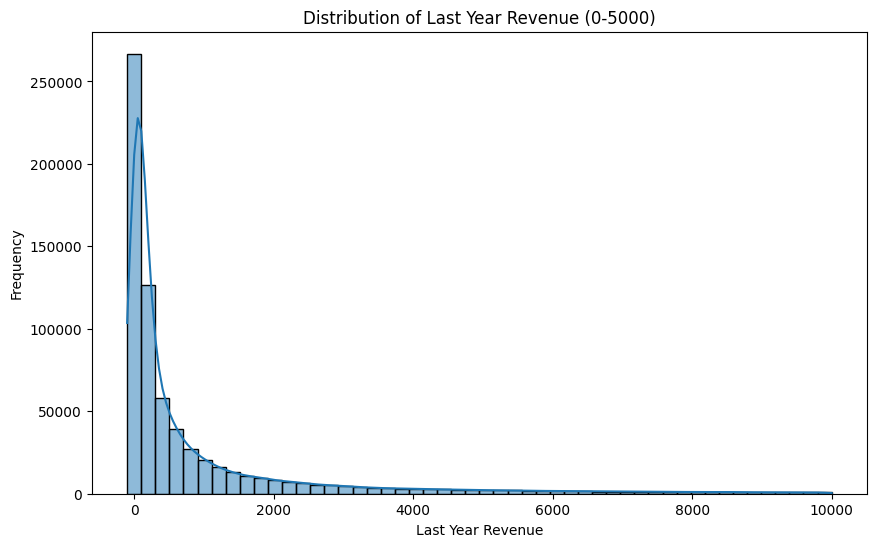

In [32]:
plt.figure(figsize=(10, 6))
filtered_revenue = merged_df['last_year_revenue'].loc[merged_df['last_year_revenue'].between(-100, 10000)]
sns.histplot(filtered_revenue, bins=50, kde=True)
plt.title('Distribution of Last Year Revenue (0-5000)')
plt.xlabel('Last Year Revenue')
plt.ylabel('Frequency')
plt.show()

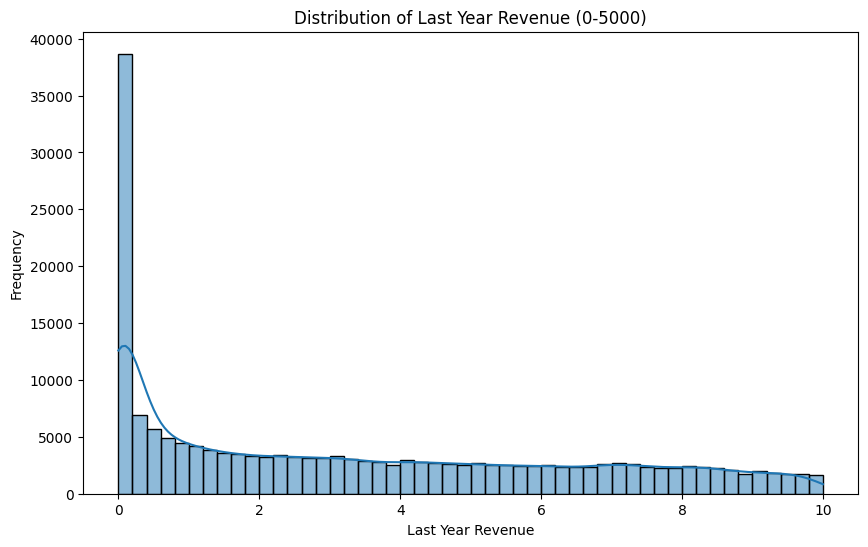

In [33]:
plt.figure(figsize=(10, 6))
filtered_revenue = merged_df['revenue'].loc[merged_df['revenue'].between(0, 10)]
sns.histplot(filtered_revenue, bins=50, kde=True)
plt.title('Distribution of Last Year Revenue (0-5000)')
plt.xlabel('Last Year Revenue')
plt.ylabel('Frequency')
plt.show()